### packages (cv2 is necessary!)

In [1]:
import cv2
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
import ffmpeg
from pathlib import Path

### load all the functions

In [45]:
def split_in_ram_digestable_parts(filepath, xy_offsets=(0,0), cropping_idxs=[(0,-1), (0,-1)], max_frame_count=5_000):
    video = imageio.get_reader(filepath)
    n_total_frames = video.count_frames()
    if n_total_frames % max_frame_count == 0:
        n_required_parts = int(n_total_frames // max_frame_count)
    else:
        n_required_parts = int(n_total_frames // max_frame_count) + 1
    idxs_of_first_and_last_frame_per_part = []
    for i in range(n_required_parts+1):
        first_frame_idx = i*max_frame_count
        if (i+1)*max_frame_count >= n_total_frames:
            last_frame_idx = n_total_frames - 1
        else:
            last_frame_idx = (i+1)*max_frame_count
        idxs_of_first_and_last_frame_per_part.append((first_frame_idx, last_frame_idx))
    video_filenames_to_concatenate = []
    for part_id, frame_idxs_range in enumerate(idxs_of_first_and_last_frame_per_part):
        frames_defished = defisheye(filepath, frame_idxs_range, xy_offsets, cropping_idxs)
        filename = f"{filepath.name[:-4]}_undistort_part_{str(part_id).zfill(3)}.mp4"
        write(frames_defished, filename)
        video_filenames_to_concatenate.append(filename)
    concatenate_videos_on_disk(video_filenames_to_concatenate)

def concatenate_videos_on_disk(filenames):
    output_filename = f'{filenames[0][:-13]}_all_parts.mp4'
    video_part_streams = [ffmpeg.input(filename) for filename in filenames]
    if len(video_part_streams) >= 2:
        concatenated_video = ffmpeg.concat(video_part_streams[0], video_part_streams[1])
        if len(video_part_streams) >= 3:
            for part_stream in video_part_streams[2:]:
                concatenated_video = ffmpeg.concat(concatenated_video, part_stream)
    else:
        concatenated_video = video_part_streams[0]
    output_stream = ffmpeg.output(concatenated_video, filename=output_filename)
    output_stream.run(overwrite_output = True)

def defisheye(filepath, frame_idxs_range, xy_offsets, cropping_idxs):
    video = imageio.get_reader(filepath)
    size_cropped = video.get_meta_data()["size"]
    frames_defished = []
    #for i in range(1):
    for i in range(frame_idxs_range[0], frame_idxs_range[1]+1):
        img = np.asarray(video.get_data(i))
        img_padded = np.pad(img, ((960 - size_cropped[1] - xy_offsets[1], xy_offsets[1]), (1280 - size_cropped[0] - xy_offsets[0] , xy_offsets[0] ), (0, 0)))
        img_undistort_bal = undistort_bal(img_padded, balance = 0)
        img_cropped = img_undistort_bal[cropping_idxs[0][0]:cropping_idxs[0][1], cropping_idxs[1][0]:cropping_idxs[1][1]]
        frames_defished.append(img_cropped)
        if i%100 == 0:
            print(i)
    return frames_defished
        
def write(frames_defished, output):
    writer = imageio.get_writer(output, fps=30)
    plt.imshow(frames_defished[0])
    plt.show()
    for index in range(len(frames_defished)):
        writer.append_data(frames_defished[index])
        if index%100 == 0:
            print(index)
    writer.close()
    
    
def undistort_bal(img, balance=0.3, dim2=DIM, dim3=None):
    #https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0
    dim1 = img.shape[:2][::-1] 
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]
    scaled_K[2][2] = 1.0
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return undistorted_img

### The parameters K and D define the camera intrinsics, such as focal length, distortion, etc.
## You can find them for each camera using opencv calibratecamera or for the bottom cam in our case using the bottomcam calibration notebook

In [2]:
#bc calibration
DIM=(1280, 960)
K=np.array([[434.84991261,   0.,         613.3162952 ],
 [  0.,         426.34362803, 454.6980908 ],
 [  0.,           0.,           1.        ]])
D=np.array([[-0.05097968],
 [ 0.07257948],
 [-0.08195595],
 [ 0.03209632]])

### Call the function split_in_ram_digestable_parts if you have large videos
### Call the function defisheye for small videos (frame_idx_range = (0, count_frames())

In [32]:
filepath = Path("/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/calibration_Side1_crop.mp4")


In [33]:
split_in_ram_digestable_parts(filepath, max_frame_count=3000)

0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1279, 959) to (1280, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


100
calibration_Side1_crop_undistort_part_000.mp4
0


[swscaler @ 0x7fbfb83e0000] Warning: data is not aligned! This can lead to a speed loss


100
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1279, 959) to (1280, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


200
calibration_Side1_crop_undistort_part_001.mp4
0


[swscaler @ 0x7f85f8048000] Warning: data is not aligned! This can lead to a speed loss


100
200


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1279, 959) to (1280, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


300
calibration_Side1_crop_undistort_part_002.mp4
0


[swscaler @ 0x7fa740048000] Warning: data is not aligned! This can lead to a speed loss


100
300


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1279, 959) to (1280, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


400
calibration_Side1_crop_undistort_part_003.mp4
0


[swscaler @ 0x7fcdf0048000] Warning: data is not aligned! This can lead to a speed loss


100
400


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1279, 959) to (1280, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


500
calibration_Side1_crop_undistort_part_004.mp4
0


[swscaler @ 0x7fd428008000] Warning: data is not aligned! This can lead to a speed loss


KeyboardInterrupt: 

### If you need to defish only single images, use the cells below
#### If you have uncropped images, skip the padding step by setting xy_offsets to (0, 0)
#### The cropping indices need to be selected based un the undistorted output image
#### If you have a different resolution than 960 x 1280 you need to adapt the line img_padded

<IPython.core.display.Javascript object>


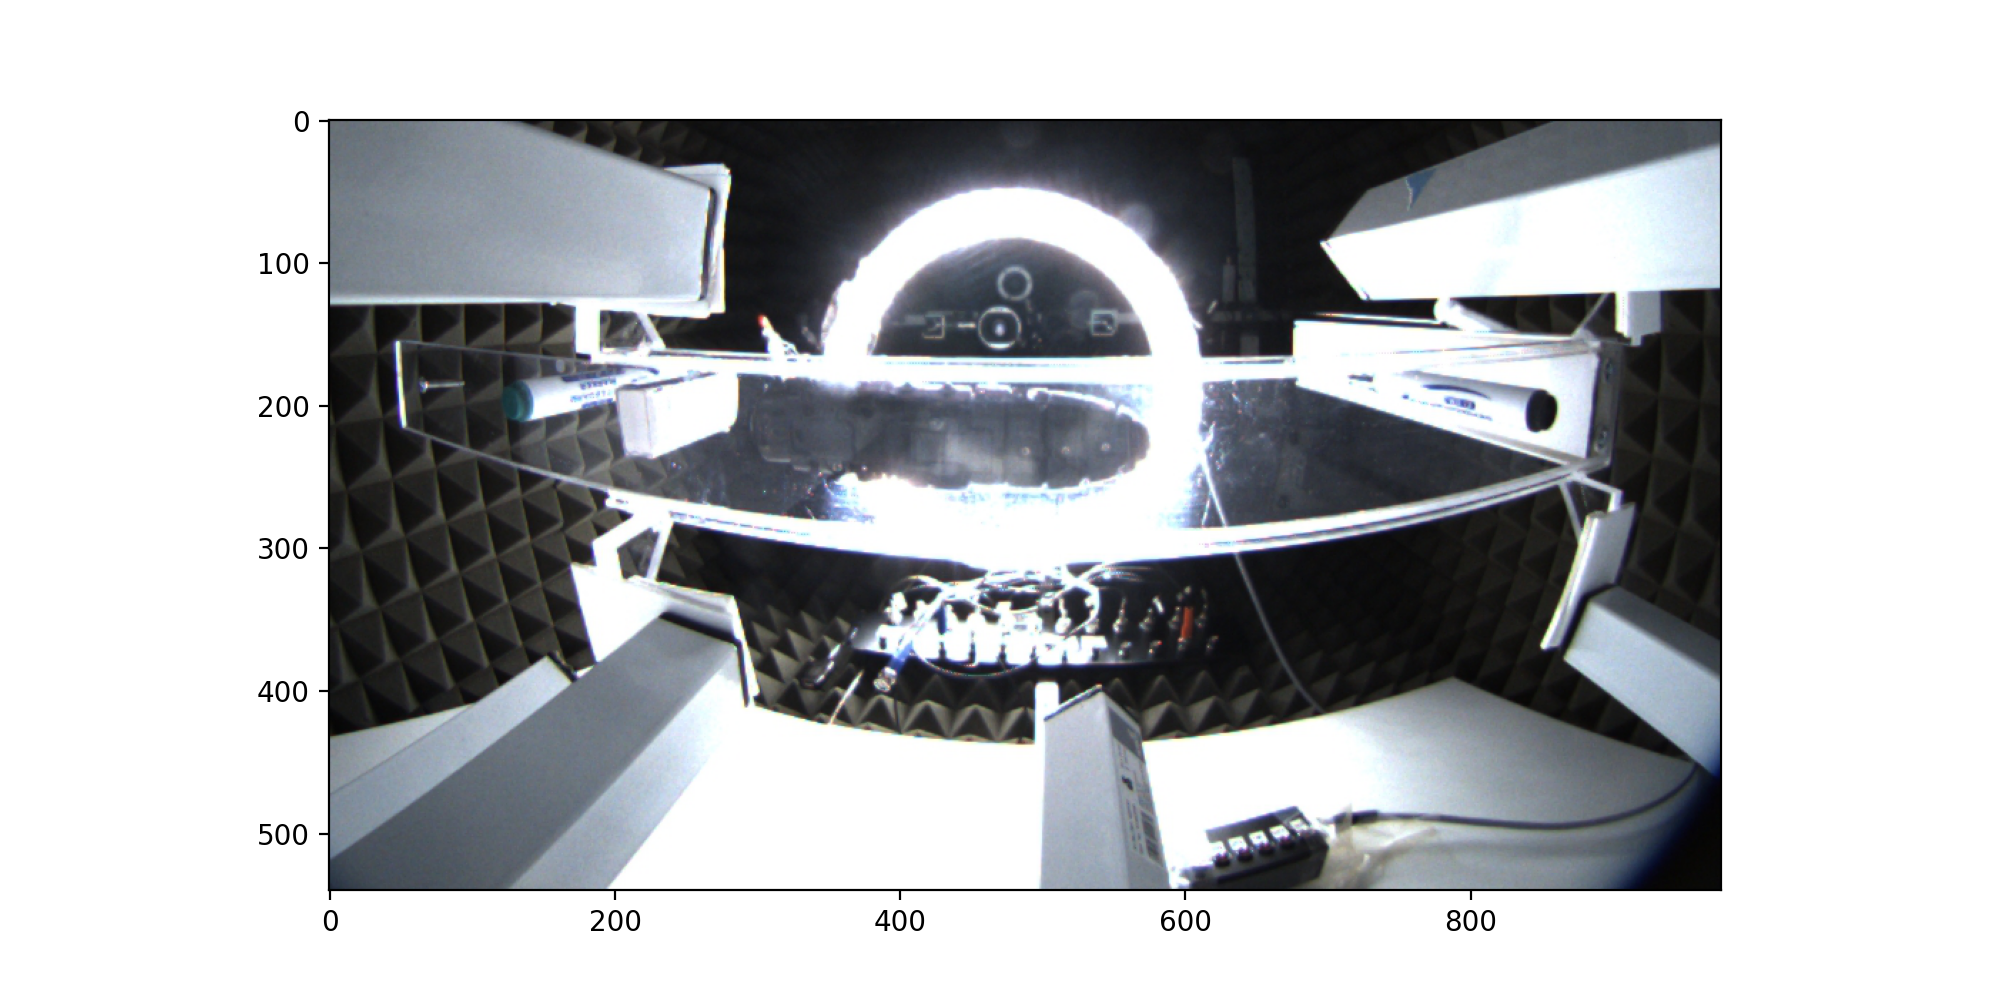

In [28]:
img = imageio.imread("/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/bottom_positions_crop.jpg")
plt.figure(figsize = (10, 5))
plt.imshow(img)
img = np.asarray(img)
size_cropped = (img.shape[1], img.shape[0])
xy_offsets = (141, 103)
cropping_idxs = [(300,720), (100,1150)]
#cropping_idxs = [(0,-1), (0,-1)]

In [30]:
img_padded = np.pad(img, ((960 - size_cropped[1] - xy_offsets[1], xy_offsets[1]), (1280 - size_cropped[0] - xy_offsets[0] , xy_offsets[0] ), (0, 0)))
img_undistort_bal = undistort_bal(img_padded, balance = 0)
img_cropped = img_undistort_bal[cropping_idxs[0][0]:cropping_idxs[0][1], cropping_idxs[1][0]:cropping_idxs[1][1]]

In [31]:
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
plt.imshow(img_cropped)
plt.show()

<IPython.core.display.Javascript object>

## If you need to concatenate videos without defishing them you can use the concatenate_videos_on_disk function if you pass the video filenames as a list as keyword argument

In [37]:
filenames = [filename for filename in os.listdir(os.getcwd()) if 'undistort_part_' in filename]
filenames.sort()
filenames

['calibration_Side1_crop_undistort_part_000.mp4',
 'calibration_Side1_crop_undistort_part_001.mp4']

In [46]:
concatenate_videos_on_disk(filenames)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/kobel/opt/anaconda3 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, 